walmart 주단위 데이터 139주로 향후 4주 예측하기

In [235]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime  
columns=['date','sales']
txs=pd.read_table('./lstmData/lstmPrac11.csv', sep=',',header=None,names=columns )
tf.reset_default_graph()

In [236]:
txs

,date,sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90
5,2010-03-12,21043.39
6,2010-03-19,22136.64
7,2010-03-26,26229.21
8,2010-04-02,57258.43
9,2010-04-09,42960.91


In [237]:
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales
def logSales(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return np.log(sales)
def sqrtSales(sales):
    return np.sqrt(sales)


def rmse(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt(sum/len(a))

def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier


In [238]:
def LSTM(txs, forecastDay, features):
    tf.set_random_seed(7)
    #Add basic date related features to the table
    year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
    dayOfWeek = lambda x: datetime.strptime(x, "%Y-%m-%d").weekday()
    month = lambda x: datetime.strptime(x, "%Y-%m-%d").month
    weekNumber = lambda x: datetime.strptime(x, "%Y-%m-%d").strftime('%V')
    txs['year'] = txs['date'].map(year)
    txs['month'] = txs['date'].map(month)
    txs['weekNumber'] = txs['date'].map(weekNumber)
    txs['dayOfWeek'] = txs['date'].map(dayOfWeek)

    #Add non-basic date related features to the table
    seasons = [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0]  # dec - feb is winter, then spring, summer, fall etc
    season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d").month - 1)]
    day_of_week01s = [0, 0, 0, 0, 0, 1, 1]
    day_of_week01 = lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d").weekday())]
    txs['season'] = txs['date'].map(season)
    txs['dayOfWeek01'] = txs['date'].map(day_of_week01)

    #Backup originalSales
    originalSales = list(txs['sales'])
    sales = list(txs['sales'])

    if features is 'DayOfWeek_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]
    elif features is'DayOfWeek01_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek01']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]

    elif features is 'WeekNumber_Month_Season_Year' :
        tempxy = [list(txs['weekNumber']), list(txs['month']), list(txs['season']),list(txs['year']), sales]

    xy = np.array(tempxy).transpose().astype(np.float)

    #Backup originalXY for denormalize
    originalXY = np.array(tempxy).transpose().astype(np.float)
    xy = minMaxNormalizer(xy)

    #TRAIN PARAMETERS
    # data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
    data_dim = 5
    # data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
    seq_length = 10
    # output_dim(=forecastDays)만큼의 다음날 y_data를 예측
    output_dim = forecastDay
    # hidden_dim은 정말 임의로 설정
    hidden_dim = 100
    # learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
    learning_rate = 0.0005

    # Build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
    x = xy
    y = xy[:, [-1]]
    dataX = []
    dataY = []
    for i in range(0, len(y) - seq_length - forecastDay+1):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length:i + seq_length + forecastDay]
        _y = np.reshape(_y, (forecastDay))
        print(_x,"->",_y)
        dataX.append(_x)
        dataY.append(_y)
    print('data set length:',len(y) - seq_length - forecastDay+1)
    
    train_size = int(len(dataY)-forecastDay)
    train_size = int(len(dataY)*0.7)    
    test_size = len(dataY) - train_size
    print('train size:' , train_size)
    print('test size:' , test_size)
    trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
    print('trainX:', trainX)
    print('testX:', testX)
    trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    Y = tf.placeholder(tf.float32, [None, forecastDay])

    cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)
    loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)
    
    denormalizedTestY=originalSales[train_size+seq_length:]
#     denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])
    
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
    
    count=0
    with tf.Session() as sess:

        # 초기화
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step
        while(1):
            count=count+1
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
            print("[step: {}] loss: {}".format(count, step_loss))
            if(step_loss<0.5):
                break

        # Test step
        # test_predict= sess.run(Y_pred, feed_dict={X: testX}
        test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalXY)
        realSale= minMaxDeNormalizer(testY[-1],originalXY)
        # Plot predictions
#         plt.plot(denormalizedTestY_feed)
        plt.plot(realSale)      #실제 sales 파란색
        plt.plot(test_predict[-1]) #예측 sales 주황색
               
        plt.xlabel("Time Period")
        plt.ylabel("Stock Price")
        plt.show()
        
    return test_predict[-1]




[[  8.68174327e-05   3.47269731e-05   0.00000000e+00   3.49006079e-02
    4.32776220e-01]
 [  1.04180919e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.99406065e-01]
 [  1.21544406e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.22243772e-01]
 [  1.38907892e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    3.36913105e-01]
 [  1.56271379e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.79008448e-01]
 [  1.73634865e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.65386619e-01]
 [  1.90998352e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.84369251e-01]
 [  2.08361838e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    4.55430535e-01]
 [  2.25725325e-04   6.94539461e-05   1.73634865e-05   3.49006079e-02
    9.94205978e-01]
 [  2.43088811e-04   6.94539461e-05   1.73634865e-05   3.49006079e-02
    7.45951182e-01]] -> [ 0.30554458  0.28033957  0.28745443  0.30236671  0.3286342   0.25651148
  0.27053059]
[[  1.041

[[  5.03541109e-04   1.21544406e-04   3.47269731e-05   3.49006079e-02
    2.66710967e-01]
 [  5.20904596e-04   1.21544406e-04   3.47269731e-05   3.49006079e-02
    2.67082024e-01]
 [  5.38268083e-04   1.38907892e-04   3.47269731e-05   3.49006079e-02
    3.04007041e-01]
 [  5.55631569e-04   1.38907892e-04   3.47269731e-05   3.49006079e-02
    2.69766072e-01]
 [  5.72995056e-04   1.38907892e-04   3.47269731e-05   3.49006079e-02
    2.73303535e-01]
 [  5.90358542e-04   1.38907892e-04   3.47269731e-05   3.49006079e-02
    2.74236649e-01]
 [  6.07722029e-04   1.56271379e-04   5.20904596e-05   3.49006079e-02
    2.82013928e-01]
 [  6.25085515e-04   1.56271379e-04   5.20904596e-05   3.49006079e-02
    3.15924123e-01]
 [  6.42449002e-04   1.56271379e-04   5.20904596e-05   3.49006079e-02
    3.36056912e-01]
 [  6.59812488e-04   1.56271379e-04   5.20904596e-05   3.49006079e-02
    3.14670132e-01]] -> [ 0.3489052   0.40609774  0.46843804  0.44351623  0.67094127  0.59450633
  0.33944557]
[[  5.209

[step: 1] loss: 113.55048370361328
[step: 2] loss: 109.21458435058594
[step: 3] loss: 104.98590087890625
[step: 4] loss: 100.85213470458984
[step: 5] loss: 96.79940795898438
[step: 6] loss: 92.81378173828125
[step: 7] loss: 88.88075256347656
[step: 8] loss: 84.98580169677734
[step: 9] loss: 81.11466217041016
[step: 10] loss: 77.253662109375
[step: 11] loss: 73.38983154296875
[step: 12] loss: 69.51152038574219
[step: 13] loss: 65.60906982421875
[step: 14] loss: 61.675750732421875
[step: 15] loss: 57.70878601074219
[step: 16] loss: 53.710418701171875
[step: 17] loss: 49.689476013183594
[step: 18] loss: 45.66318893432617
[step: 19] loss: 41.659732818603516
[step: 20] loss: 37.721153259277344
[step: 21] loss: 33.90708923339844
[step: 22] loss: 30.298763275146484
[step: 23] loss: 27.002649307250977
[step: 24] loss: 24.15163803100586
[step: 25] loss: 21.898868560791016
[step: 26] loss: 20.3945369720459
[step: 27] loss: 19.733543395996094
[step: 28] loss: 19.87580108642578
[step: 29] loss: 20

[step: 229] loss: 15.436954498291016
[step: 230] loss: 15.424861907958984
[step: 231] loss: 15.412550926208496
[step: 232] loss: 15.400032997131348
[step: 233] loss: 15.387287139892578
[step: 234] loss: 15.374319076538086
[step: 235] loss: 15.361112594604492
[step: 236] loss: 15.347667694091797
[step: 237] loss: 15.333978652954102
[step: 238] loss: 15.320036888122559
[step: 239] loss: 15.30583381652832
[step: 240] loss: 15.291366577148438
[step: 241] loss: 15.27662467956543
[step: 242] loss: 15.261611938476562
[step: 243] loss: 15.246313095092773
[step: 244] loss: 15.230731010437012
[step: 245] loss: 15.214852333068848
[step: 246] loss: 15.198680877685547
[step: 247] loss: 15.182205200195312
[step: 248] loss: 15.165428161621094
[step: 249] loss: 15.148344039916992
[step: 250] loss: 15.130950927734375
[step: 251] loss: 15.11324691772461
[step: 252] loss: 15.095234870910645
[step: 253] loss: 15.076910018920898
[step: 254] loss: 15.058282852172852
[step: 255] loss: 15.039352416992188
[ste

[step: 455] loss: 13.379521369934082
[step: 456] loss: 13.37415885925293
[step: 457] loss: 13.3687744140625
[step: 458] loss: 13.363371849060059
[step: 459] loss: 13.357945442199707
[step: 460] loss: 13.352497100830078
[step: 461] loss: 13.347025871276855
[step: 462] loss: 13.341533660888672
[step: 463] loss: 13.336018562316895
[step: 464] loss: 13.330479621887207
[step: 465] loss: 13.324913024902344
[step: 466] loss: 13.319327354431152
[step: 467] loss: 13.313713073730469
[step: 468] loss: 13.308073043823242
[step: 469] loss: 13.302410125732422
[step: 470] loss: 13.29671859741211
[step: 471] loss: 13.29100227355957
[step: 472] loss: 13.285258293151855
[step: 473] loss: 13.279485702514648
[step: 474] loss: 13.273686408996582
[step: 475] loss: 13.267852783203125
[step: 476] loss: 13.261993408203125
[step: 477] loss: 13.256105422973633
[step: 478] loss: 13.250188827514648
[step: 479] loss: 13.244233131408691
[step: 480] loss: 13.238251686096191
[step: 481] loss: 13.232236862182617
[step:

[step: 686] loss: 12.044473648071289
[step: 687] loss: 12.041263580322266
[step: 688] loss: 12.037906646728516
[step: 689] loss: 12.034423828125
[step: 690] loss: 12.031042098999023
[step: 691] loss: 12.027782440185547
[step: 692] loss: 12.024458885192871
[step: 693] loss: 12.02103328704834
[step: 694] loss: 12.017622947692871
[step: 695] loss: 12.014307975769043
[step: 696] loss: 12.011006355285645
[step: 697] loss: 12.007640838623047
[step: 698] loss: 12.004234313964844
[step: 699] loss: 12.000850677490234
[step: 700] loss: 11.997514724731445
[step: 701] loss: 11.994190216064453
[step: 702] loss: 11.99083137512207
[step: 703] loss: 11.987438201904297
[step: 704] loss: 11.984046936035156
[step: 705] loss: 11.980674743652344
[step: 706] loss: 11.97732162475586
[step: 707] loss: 11.973962783813477
[step: 708] loss: 11.97059154510498
[step: 709] loss: 11.967201232910156
[step: 710] loss: 11.963802337646484
[step: 711] loss: 11.96040153503418
[step: 712] loss: 11.957008361816406
[step: 71

[step: 916] loss: 11.225390434265137
[step: 917] loss: 11.220293045043945
[step: 918] loss: 11.215226173400879
[step: 919] loss: 11.210275650024414
[step: 920] loss: 11.205223083496094
[step: 921] loss: 11.200016021728516
[step: 922] loss: 11.194809913635254
[step: 923] loss: 11.189665794372559
[step: 924] loss: 11.18446159362793
[step: 925] loss: 11.17913818359375
[step: 926] loss: 11.173760414123535
[step: 927] loss: 11.16840934753418
[step: 928] loss: 11.163039207458496
[step: 929] loss: 11.157588958740234
[step: 930] loss: 11.152059555053711
[step: 931] loss: 11.146486282348633
[step: 932] loss: 11.14090633392334
[step: 933] loss: 11.135293960571289
[step: 934] loss: 11.12962532043457
[step: 935] loss: 11.123886108398438
[step: 936] loss: 11.118085861206055
[step: 937] loss: 11.11224365234375
[step: 938] loss: 11.106365203857422
[step: 939] loss: 11.100444793701172
[step: 940] loss: 11.094476699829102
[step: 941] loss: 11.08845043182373
[step: 942] loss: 11.082367897033691
[step: 9

[step: 1143] loss: 9.833660125732422
[step: 1144] loss: 9.826623916625977
[step: 1145] loss: 9.819784164428711
[step: 1146] loss: 9.812980651855469
[step: 1147] loss: 9.806046485900879
[step: 1148] loss: 9.798968315124512
[step: 1149] loss: 9.791769027709961
[step: 1150] loss: 9.784525871276855
[step: 1151] loss: 9.777268409729004
[step: 1152] loss: 9.770030975341797
[step: 1153] loss: 9.762832641601562
[step: 1154] loss: 9.755718231201172
[step: 1155] loss: 9.748826026916504
[step: 1156] loss: 9.74243450164795
[step: 1157] loss: 9.737462997436523
[step: 1158] loss: 9.73613452911377
[step: 1159] loss: 9.74635124206543
[step: 1160] loss: 9.786678314208984
[step: 1161] loss: 9.93890380859375
[step: 1162] loss: 10.302835464477539
[step: 1163] loss: 11.469165802001953
[step: 1164] loss: 11.349489212036133
[step: 1165] loss: 10.99930191040039
[step: 1166] loss: 9.713382720947266
[step: 1167] loss: 10.905214309692383
[step: 1168] loss: 12.042289733886719
[step: 1169] loss: 9.90267276763916
[

[step: 1372] loss: 9.131765365600586
[step: 1373] loss: 9.076289176940918
[step: 1374] loss: 9.08224105834961
[step: 1375] loss: 9.090375900268555
[step: 1376] loss: 9.045454978942871
[step: 1377] loss: 9.073802947998047
[step: 1378] loss: 9.044378280639648
[step: 1379] loss: 9.034863471984863
[step: 1380] loss: 9.045692443847656
[step: 1381] loss: 9.011946678161621
[step: 1382] loss: 9.025808334350586
[step: 1383] loss: 9.008428573608398
[step: 1384] loss: 8.997577667236328
[step: 1385] loss: 9.002859115600586
[step: 1386] loss: 8.979969024658203
[step: 1387] loss: 8.986148834228516
[step: 1388] loss: 8.972190856933594
[step: 1389] loss: 8.965372085571289
[step: 1390] loss: 8.964187622070312
[step: 1391] loss: 8.949007034301758
[step: 1392] loss: 8.951194763183594
[step: 1393] loss: 8.938013076782227
[step: 1394] loss: 8.934954643249512
[step: 1395] loss: 8.928756713867188
[step: 1396] loss: 8.919584274291992
[step: 1397] loss: 8.91794204711914
[step: 1398] loss: 8.906898498535156
[st

[step: 1599] loss: 7.990222454071045
[step: 1600] loss: 8.021889686584473
[step: 1601] loss: 7.986512184143066
[step: 1602] loss: 7.988083362579346
[step: 1603] loss: 7.981041431427002
[step: 1604] loss: 7.956091403961182
[step: 1605] loss: 7.974833965301514
[step: 1606] loss: 7.936363220214844
[step: 1607] loss: 7.9564619064331055
[step: 1608] loss: 7.928061008453369
[step: 1609] loss: 7.929750919342041
[step: 1610] loss: 7.9231462478637695
[step: 1611] loss: 7.905354976654053
[step: 1612] loss: 7.912481784820557
[step: 1613] loss: 7.890893459320068
[step: 1614] loss: 7.894163131713867
[step: 1615] loss: 7.883106231689453
[step: 1616] loss: 7.873022079467773
[step: 1617] loss: 7.874144077301025
[step: 1618] loss: 7.8584184646606445
[step: 1619] loss: 7.857738018035889
[step: 1620] loss: 7.8501739501953125
[step: 1621] loss: 7.839733600616455
[step: 1622] loss: 7.839129447937012
[step: 1623] loss: 7.828098773956299
[step: 1624] loss: 7.822759628295898
[step: 1625] loss: 7.8193292617797

[step: 1820] loss: 6.88407039642334
[step: 1821] loss: 6.878703594207764
[step: 1822] loss: 6.873335361480713
[step: 1823] loss: 6.867968559265137
[step: 1824] loss: 6.862600803375244
[step: 1825] loss: 6.857244491577148
[step: 1826] loss: 6.851885795593262
[step: 1827] loss: 6.846540451049805
[step: 1828] loss: 6.841213703155518
[step: 1829] loss: 6.8359174728393555
[step: 1830] loss: 6.830690860748291
[step: 1831] loss: 6.8256049156188965
[step: 1832] loss: 6.82080078125
[step: 1833] loss: 6.81663703918457
[step: 1834] loss: 6.813837051391602
[step: 1835] loss: 6.81428861618042
[step: 1836] loss: 6.821911334991455
[step: 1837] loss: 6.848149299621582
[step: 1838] loss: 6.914730072021484
[step: 1839] loss: 7.096224784851074
[step: 1840] loss: 7.477756977081299
[step: 1841] loss: 8.444906234741211
[step: 1842] loss: 9.376909255981445
[step: 1843] loss: 10.475869178771973
[step: 1844] loss: 8.038141250610352
[step: 1845] loss: 6.866901397705078
[step: 1846] loss: 8.185665130615234
[step

[step: 2046] loss: 7.531370639801025
[step: 2047] loss: 6.74040412902832
[step: 2048] loss: 5.992555141448975
[step: 2049] loss: 5.934745788574219
[step: 2050] loss: 6.417402267456055
[step: 2051] loss: 6.697197914123535
[step: 2052] loss: 6.233452796936035
[step: 2053] loss: 5.8565826416015625
[step: 2054] loss: 6.049317359924316
[step: 2055] loss: 6.300868511199951
[step: 2056] loss: 6.103421211242676
[step: 2057] loss: 5.834135055541992
[step: 2058] loss: 5.984065055847168
[step: 2059] loss: 6.1677775382995605
[step: 2060] loss: 5.990408420562744
[step: 2061] loss: 5.813753604888916
[step: 2062] loss: 5.935678482055664
[step: 2063] loss: 6.044799327850342
[step: 2064] loss: 5.913268089294434
[step: 2065] loss: 5.795724868774414
[step: 2066] loss: 5.883060932159424
[step: 2067] loss: 5.966337203979492
[step: 2068] loss: 5.863677978515625
[step: 2069] loss: 5.776018142700195
[step: 2070] loss: 5.822834491729736
[step: 2071] loss: 5.888762474060059
[step: 2072] loss: 5.826279640197754


[step: 2269] loss: 4.918698310852051
[step: 2270] loss: 4.869498252868652
[step: 2271] loss: 4.91412353515625
[step: 2272] loss: 4.989826679229736
[step: 2273] loss: 5.013955116271973
[step: 2274] loss: 4.976161479949951
[step: 2275] loss: 4.8965606689453125
[step: 2276] loss: 4.846367359161377
[step: 2277] loss: 4.847694396972656
[step: 2278] loss: 4.881802082061768
[step: 2279] loss: 4.917037010192871
[step: 2280] loss: 4.919797897338867
[step: 2281] loss: 4.894931793212891
[step: 2282] loss: 4.852634429931641
[step: 2283] loss: 4.820029258728027
[step: 2284] loss: 4.80570650100708
[step: 2285] loss: 4.8091607093811035
[step: 2286] loss: 4.823053359985352
[step: 2287] loss: 4.836416244506836
[step: 2288] loss: 4.845432281494141
[step: 2289] loss: 4.84456729888916
[step: 2290] loss: 4.839774131774902
[step: 2291] loss: 4.828032493591309
[step: 2292] loss: 4.816802978515625
[step: 2293] loss: 4.80328369140625
[step: 2294] loss: 4.792193412780762
[step: 2295] loss: 4.782161712646484
[st

[step: 2500] loss: 4.0051116943359375
[step: 2501] loss: 4.010653495788574
[step: 2502] loss: 4.016810417175293
[step: 2503] loss: 4.014141082763672
[step: 2504] loss: 4.008393287658691
[step: 2505] loss: 4.002254962921143
[step: 2506] loss: 3.994079113006592
[step: 2507] loss: 3.9836313724517822
[step: 2508] loss: 3.974827289581299
[step: 2509] loss: 3.970982313156128
[step: 2510] loss: 3.969491958618164
[step: 2511] loss: 3.9677305221557617
[step: 2512] loss: 3.965395927429199
[step: 2513] loss: 3.964867115020752
[step: 2514] loss: 3.965388298034668
[step: 2515] loss: 3.9656684398651123
[step: 2516] loss: 3.9658331871032715
[step: 2517] loss: 3.967092990875244
[step: 2518] loss: 3.9729113578796387
[step: 2519] loss: 3.9804229736328125
[step: 2520] loss: 3.9979043006896973
[step: 2521] loss: 4.0187482833862305
[step: 2522] loss: 4.066089153289795
[step: 2523] loss: 4.118424892425537
[step: 2524] loss: 4.234470367431641
[step: 2525] loss: 4.3320207595825195
[step: 2526] loss: 4.5513143

[step: 2725] loss: 3.4760189056396484
[step: 2726] loss: 3.4789557456970215
[step: 2727] loss: 3.4338810443878174
[step: 2728] loss: 3.3914365768432617
[step: 2729] loss: 3.345019578933716
[step: 2730] loss: 3.3170125484466553
[step: 2731] loss: 3.302438974380493
[step: 2732] loss: 3.2999727725982666
[step: 2733] loss: 3.3068933486938477
[step: 2734] loss: 3.320767402648926
[step: 2735] loss: 3.3427016735076904
[step: 2736] loss: 3.361584186553955
[step: 2737] loss: 3.390028476715088
[step: 2738] loss: 3.4021248817443848
[step: 2739] loss: 3.432384729385376
[step: 2740] loss: 3.439560890197754
[step: 2741] loss: 3.4767494201660156
[step: 2742] loss: 3.483768939971924
[step: 2743] loss: 3.524850368499756
[step: 2744] loss: 3.5201497077941895
[step: 2745] loss: 3.5455784797668457
[step: 2746] loss: 3.5107157230377197
[step: 2747] loss: 3.4994704723358154
[step: 2748] loss: 3.435382604598999
[step: 2749] loss: 3.3910603523254395
[step: 2750] loss: 3.32846736907959
[step: 2751] loss: 3.285

[step: 2944] loss: 2.9386634826660156
[step: 2945] loss: 2.9425058364868164
[step: 2946] loss: 2.9280333518981934
[step: 2947] loss: 2.927455425262451
[step: 2948] loss: 2.911308765411377
[step: 2949] loss: 2.9202170372009277
[step: 2950] loss: 2.9081177711486816
[step: 2951] loss: 2.922654628753662
[step: 2952] loss: 2.9057443141937256
[step: 2953] loss: 2.911097526550293
[step: 2954] loss: 2.883265733718872
[step: 2955] loss: 2.8752188682556152
[step: 2956] loss: 2.8471744060516357
[step: 2957] loss: 2.838621139526367
[step: 2958] loss: 2.824306011199951
[step: 2959] loss: 2.8247756958007812
[step: 2960] loss: 2.8236725330352783
[step: 2961] loss: 2.8306002616882324
[step: 2962] loss: 2.8359487056732178
[step: 2963] loss: 2.8501596450805664
[step: 2964] loss: 2.864950656890869
[step: 2965] loss: 2.9034600257873535
[step: 2966] loss: 2.9416189193725586
[step: 2967] loss: 3.035578966140747
[step: 2968] loss: 3.100085735321045
[step: 2969] loss: 3.264600992202759
[step: 2970] loss: 3.28

[step: 3171] loss: 3.065659523010254
[step: 3172] loss: 3.182720422744751
[step: 3173] loss: 2.9102635383605957
[step: 3174] loss: 2.466353416442871
[step: 3175] loss: 2.5726592540740967
[step: 3176] loss: 2.9449777603149414
[step: 3177] loss: 2.7574353218078613
[step: 3178] loss: 2.446298122406006
[step: 3179] loss: 2.4288387298583984
[step: 3180] loss: 2.645785331726074
[step: 3181] loss: 2.7436704635620117
[step: 3182] loss: 2.488255262374878
[step: 3183] loss: 2.355625867843628
[step: 3184] loss: 2.481323003768921
[step: 3185] loss: 2.583223581314087
[step: 3186] loss: 2.529229164123535
[step: 3187] loss: 2.37092924118042
[step: 3188] loss: 2.359157085418701
[step: 3189] loss: 2.4670658111572266
[step: 3190] loss: 2.4922642707824707
[step: 3191] loss: 2.4233522415161133
[step: 3192] loss: 2.3368053436279297
[step: 3193] loss: 2.3478217124938965
[step: 3194] loss: 2.4134883880615234
[step: 3195] loss: 2.428219795227051
[step: 3196] loss: 2.3864619731903076
[step: 3197] loss: 2.32820

[step: 3390] loss: 2.1287012100219727
[step: 3391] loss: 2.137744188308716
[step: 3392] loss: 2.149014949798584
[step: 3393] loss: 2.1722428798675537
[step: 3394] loss: 2.2009294033050537
[step: 3395] loss: 2.2573421001434326
[step: 3396] loss: 2.3227639198303223
[step: 3397] loss: 2.455472946166992
[step: 3398] loss: 2.574795722961426
[step: 3399] loss: 2.8221776485443115
[step: 3400] loss: 2.910228729248047
[step: 3401] loss: 3.1120858192443848
[step: 3402] loss: 2.912558078765869
[step: 3403] loss: 2.7237627506256104
[step: 3404] loss: 2.3706772327423096
[step: 3405] loss: 2.1397883892059326
[step: 3406] loss: 2.0885348320007324
[step: 3407] loss: 2.190603256225586
[step: 3408] loss: 2.3528976440429688
[step: 3409] loss: 2.3872361183166504
[step: 3410] loss: 2.335844039916992
[step: 3411] loss: 2.1845669746398926
[step: 3412] loss: 2.0808520317077637
[step: 3413] loss: 2.0735340118408203
[step: 3414] loss: 2.1405177116394043
[step: 3415] loss: 2.2256765365600586
[step: 3416] loss: 2

[step: 3611] loss: 1.8885340690612793
[step: 3612] loss: 1.8785641193389893
[step: 3613] loss: 1.874624252319336
[step: 3614] loss: 1.8777655363082886
[step: 3615] loss: 1.8829854726791382
[step: 3616] loss: 1.8846584558486938
[step: 3617] loss: 1.881028413772583
[step: 3618] loss: 1.8757798671722412
[step: 3619] loss: 1.8724766969680786
[step: 3620] loss: 1.8721874952316284
[step: 3621] loss: 1.8728673458099365
[step: 3622] loss: 1.8719844818115234
[step: 3623] loss: 1.8689837455749512
[step: 3624] loss: 1.865196943283081
[step: 3625] loss: 1.862461805343628
[step: 3626] loss: 1.8616725206375122
[step: 3627] loss: 1.8619136810302734
[step: 3628] loss: 1.8622143268585205
[step: 3629] loss: 1.861675500869751
[step: 3630] loss: 1.8609825372695923
[step: 3631] loss: 1.8610345125198364
[step: 3632] loss: 1.8635826110839844
[step: 3633] loss: 1.869590401649475
[step: 3634] loss: 1.8817903995513916
[step: 3635] loss: 1.902742624282837
[step: 3636] loss: 1.943650722503662
[step: 3637] loss: 2

[step: 3835] loss: 1.8211990594863892
[step: 3836] loss: 1.7447521686553955
[step: 3837] loss: 1.8790748119354248
[step: 3838] loss: 2.0087389945983887
[step: 3839] loss: 1.9201823472976685
[step: 3840] loss: 1.7790508270263672
[step: 3841] loss: 1.7359586954116821
[step: 3842] loss: 1.8116949796676636
[step: 3843] loss: 1.8877248764038086
[step: 3844] loss: 1.8506908416748047
[step: 3845] loss: 1.7734999656677246
[step: 3846] loss: 1.7329208850860596
[step: 3847] loss: 1.7576920986175537
[step: 3848] loss: 1.799422025680542
[step: 3849] loss: 1.8035669326782227
[step: 3850] loss: 1.7773383855819702
[step: 3851] loss: 1.7424153089523315
[step: 3852] loss: 1.7295236587524414
[step: 3853] loss: 1.7366812229156494
[step: 3854] loss: 1.7499874830245972
[step: 3855] loss: 1.7563269138336182
[step: 3856] loss: 1.7506946325302124
[step: 3857] loss: 1.7405335903167725
[step: 3858] loss: 1.7252981662750244
[step: 3859] loss: 1.714186191558838
[step: 3860] loss: 1.7107698917388916
[step: 3861] l

[step: 4062] loss: 1.608923077583313
[step: 4063] loss: 1.6248371601104736
[step: 4064] loss: 1.6471121311187744
[step: 4065] loss: 1.653531789779663
[step: 4066] loss: 1.6463390588760376
[step: 4067] loss: 1.623856544494629
[step: 4068] loss: 1.6029713153839111
[step: 4069] loss: 1.5919530391693115
[step: 4070] loss: 1.5962200164794922
[step: 4071] loss: 1.6116347312927246
[step: 4072] loss: 1.6225731372833252
[step: 4073] loss: 1.621386170387268
[step: 4074] loss: 1.6059155464172363
[step: 4075] loss: 1.5899169445037842
[step: 4076] loss: 1.581296682357788
[step: 4077] loss: 1.5817424058914185
[step: 4078] loss: 1.5856356620788574
[step: 4079] loss: 1.5881754159927368
[step: 4080] loss: 1.5896693468093872
[step: 4081] loss: 1.5910766124725342
[step: 4082] loss: 1.5937010049819946
[step: 4083] loss: 1.5944981575012207
[step: 4084] loss: 1.5921739339828491
[step: 4085] loss: 1.5872468948364258
[step: 4086] loss: 1.5823886394500732
[step: 4087] loss: 1.5789499282836914
[step: 4088] loss

[step: 4283] loss: 1.4954440593719482
[step: 4284] loss: 1.5061124563217163
[step: 4285] loss: 1.5264443159103394
[step: 4286] loss: 1.5589556694030762
[step: 4287] loss: 1.622688889503479
[step: 4288] loss: 1.7194631099700928
[step: 4289] loss: 1.917612910270691
[step: 4290] loss: 2.1677021980285645
[step: 4291] loss: 2.679070472717285
[step: 4292] loss: 3.002849578857422
[step: 4293] loss: 3.5620622634887695
[step: 4294] loss: 3.085409164428711
[step: 4295] loss: 2.506145477294922
[step: 4296] loss: 1.7379984855651855
[step: 4297] loss: 1.5331217050552368
[step: 4298] loss: 1.884918212890625
[step: 4299] loss: 2.2008261680603027
[step: 4300] loss: 2.167468786239624
[step: 4301] loss: 1.7055168151855469
[step: 4302] loss: 1.5121526718139648
[step: 4303] loss: 1.7281792163848877
[step: 4304] loss: 1.9248323440551758
[step: 4305] loss: 1.8480812311172485
[step: 4306] loss: 1.5651293992996216
[step: 4307] loss: 1.5065207481384277
[step: 4308] loss: 1.6769907474517822
[step: 4309] loss: 1

[step: 4502] loss: 1.597697138786316
[step: 4503] loss: 1.4677983522415161
[step: 4504] loss: 1.875435709953308
[step: 4505] loss: 2.290635347366333
[step: 4506] loss: 1.9913580417633057
[step: 4507] loss: 1.5429586172103882
[step: 4508] loss: 1.4515371322631836
[step: 4509] loss: 1.7325903177261353
[step: 4510] loss: 1.9341466426849365
[step: 4511] loss: 1.6792851686477661
[step: 4512] loss: 1.424752950668335
[step: 4513] loss: 1.4760570526123047
[step: 4514] loss: 1.6667168140411377
[step: 4515] loss: 1.7102599143981934
[step: 4516] loss: 1.5185060501098633
[step: 4517] loss: 1.4040323495864868
[step: 4518] loss: 1.476738691329956
[step: 4519] loss: 1.577850580215454
[step: 4520] loss: 1.5711946487426758
[step: 4521] loss: 1.458254337310791
[step: 4522] loss: 1.4091365337371826
[step: 4523] loss: 1.4528570175170898
[step: 4524] loss: 1.5000109672546387
[step: 4525] loss: 1.4918768405914307
[step: 4526] loss: 1.4362741708755493
[step: 4527] loss: 1.4093220233917236
[step: 4528] loss: 

[step: 4722] loss: 1.3216310739517212
[step: 4723] loss: 1.310316801071167
[step: 4724] loss: 1.3058513402938843
[step: 4725] loss: 1.3080332279205322
[step: 4726] loss: 1.310279369354248
[step: 4727] loss: 1.3086016178131104
[step: 4728] loss: 1.3064022064208984
[step: 4729] loss: 1.306516408920288
[step: 4730] loss: 1.3085598945617676
[step: 4731] loss: 1.308607578277588
[step: 4732] loss: 1.3049955368041992
[step: 4733] loss: 1.3001434803009033
[step: 4734] loss: 1.297153353691101
[step: 4735] loss: 1.2969714403152466
[step: 4736] loss: 1.2975044250488281
[step: 4737] loss: 1.2970929145812988
[step: 4738] loss: 1.2957556247711182
[step: 4739] loss: 1.2948015928268433
[step: 4740] loss: 1.2952125072479248
[step: 4741] loss: 1.2962474822998047
[step: 4742] loss: 1.2968008518218994
[step: 4743] loss: 1.2965031862258911
[step: 4744] loss: 1.2958165407180786
[step: 4745] loss: 1.2959113121032715
[step: 4746] loss: 1.2967796325683594
[step: 4747] loss: 1.2984225749969482
[step: 4748] loss

[step: 4948] loss: 2.1189160346984863
[step: 4949] loss: 2.1975278854370117
[step: 4950] loss: 2.325995922088623
[step: 4951] loss: 2.060314178466797
[step: 4952] loss: 1.7700873613357544
[step: 4953] loss: 1.4095354080200195
[step: 4954] loss: 1.2401816844940186
[step: 4955] loss: 1.2953121662139893
[step: 4956] loss: 1.4690651893615723
[step: 4957] loss: 1.615341305732727
[step: 4958] loss: 1.5626585483551025
[step: 4959] loss: 1.4178571701049805
[step: 4960] loss: 1.267865777015686
[step: 4961] loss: 1.2356376647949219
[step: 4962] loss: 1.3089717626571655
[step: 4963] loss: 1.3967386484146118
[step: 4964] loss: 1.4341351985931396
[step: 4965] loss: 1.377877950668335
[step: 4966] loss: 1.300889253616333
[step: 4967] loss: 1.2441225051879883
[step: 4968] loss: 1.2394860982894897
[step: 4969] loss: 1.2699624300003052
[step: 4970] loss: 1.303659439086914
[step: 4971] loss: 1.3231918811798096
[step: 4972] loss: 1.312208890914917
[step: 4973] loss: 1.2896331548690796
[step: 4974] loss: 1

[step: 5176] loss: 1.1821320056915283
[step: 5177] loss: 1.191140055656433
[step: 5178] loss: 1.1971697807312012
[step: 5179] loss: 1.19295334815979
[step: 5180] loss: 1.1812189817428589
[step: 5181] loss: 1.1666960716247559
[step: 5182] loss: 1.1590886116027832
[step: 5183] loss: 1.1612707376480103
[step: 5184] loss: 1.1697067022323608
[step: 5185] loss: 1.1772499084472656
[step: 5186] loss: 1.1780385971069336
[step: 5187] loss: 1.1743011474609375
[step: 5188] loss: 1.1681779623031616
[step: 5189] loss: 1.1637424230575562
[step: 5190] loss: 1.1607327461242676
[step: 5191] loss: 1.1580983400344849
[step: 5192] loss: 1.1553685665130615
[step: 5193] loss: 1.1529992818832397
[step: 5194] loss: 1.1523635387420654
[step: 5195] loss: 1.1536520719528198
[step: 5196] loss: 1.1558828353881836
[step: 5197] loss: 1.1578896045684814
[step: 5198] loss: 1.1590278148651123
[step: 5199] loss: 1.1595977544784546
[step: 5200] loss: 1.1606764793395996
[step: 5201] loss: 1.1623948812484741
[step: 5202] lo

[step: 5404] loss: 1.1813266277313232
[step: 5405] loss: 1.2338221073150635
[step: 5406] loss: 1.2561105489730835
[step: 5407] loss: 1.259488821029663
[step: 5408] loss: 1.2273900508880615
[step: 5409] loss: 1.1905275583267212
[step: 5410] loss: 1.1480696201324463
[step: 5411] loss: 1.1175532341003418
[step: 5412] loss: 1.099591612815857
[step: 5413] loss: 1.0948212146759033
[step: 5414] loss: 1.0999906063079834
[step: 5415] loss: 1.1113629341125488
[step: 5416] loss: 1.1263068914413452
[step: 5417] loss: 1.1412408351898193
[step: 5418] loss: 1.1581820249557495
[step: 5419] loss: 1.1711177825927734
[step: 5420] loss: 1.1878480911254883
[step: 5421] loss: 1.1978318691253662
[step: 5422] loss: 1.214850902557373
[step: 5423] loss: 1.2236863374710083
[step: 5424] loss: 1.2436528205871582
[step: 5425] loss: 1.254309892654419
[step: 5426] loss: 1.2796217203140259
[step: 5427] loss: 1.2924182415008545
[step: 5428] loss: 1.321512222290039
[step: 5429] loss: 1.3313252925872803
[step: 5430] loss

[step: 5631] loss: 1.0912525653839111
[step: 5632] loss: 1.1071932315826416
[step: 5633] loss: 1.1186776161193848
[step: 5634] loss: 1.1330199241638184
[step: 5635] loss: 1.1409590244293213
[step: 5636] loss: 1.1544783115386963
[step: 5637] loss: 1.1597893238067627
[step: 5638] loss: 1.1731683015823364
[step: 5639] loss: 1.1772370338439941
[step: 5640] loss: 1.192079782485962
[step: 5641] loss: 1.1970595121383667
[step: 5642] loss: 1.2149494886398315
[step: 5643] loss: 1.2212755680084229
[step: 5644] loss: 1.2412824630737305
[step: 5645] loss: 1.2460658550262451
[step: 5646] loss: 1.2641315460205078
[step: 5647] loss: 1.261954665184021
[step: 5648] loss: 1.2717617750167847
[step: 5649] loss: 1.257265567779541
[step: 5650] loss: 1.2527978420257568
[step: 5651] loss: 1.2245903015136719
[step: 5652] loss: 1.2045572996139526
[step: 5653] loss: 1.1683529615402222
[step: 5654] loss: 1.1398298740386963
[step: 5655] loss: 1.1066224575042725
[step: 5656] loss: 1.081357717514038
[step: 5657] los

[step: 5857] loss: 1.0345345735549927
[step: 5858] loss: 1.0530081987380981
[step: 5859] loss: 1.0779597759246826
[step: 5860] loss: 1.1211154460906982
[step: 5861] loss: 1.1772973537445068
[step: 5862] loss: 1.2769384384155273
[step: 5863] loss: 1.3925977945327759
[step: 5864] loss: 1.597517490386963
[step: 5865] loss: 1.7657220363616943
[step: 5866] loss: 2.033559799194336
[step: 5867] loss: 2.0411572456359863
[step: 5868] loss: 2.0159831047058105
[step: 5869] loss: 1.6366136074066162
[step: 5870] loss: 1.2734723091125488
[step: 5871] loss: 1.0348737239837646
[step: 5872] loss: 1.0493645668029785
[step: 5873] loss: 1.2375661134719849
[step: 5874] loss: 1.3759636878967285
[step: 5875] loss: 1.3770270347595215
[step: 5876] loss: 1.192176342010498
[step: 5877] loss: 1.0332845449447632
[step: 5878] loss: 1.003907322883606
[step: 5879] loss: 1.0931789875030518
[step: 5880] loss: 1.2022696733474731
[step: 5881] loss: 1.2134976387023926
[step: 5882] loss: 1.148210048675537
[step: 5883] loss

[step: 6079] loss: 0.9439470767974854
[step: 6080] loss: 0.9443928599357605
[step: 6081] loss: 0.9447311758995056
[step: 6082] loss: 0.9448422193527222
[step: 6083] loss: 0.9449570775032043
[step: 6084] loss: 0.9454435110092163
[step: 6085] loss: 0.9467741250991821
[step: 6086] loss: 0.9493919014930725
[step: 6087] loss: 0.9541947841644287
[step: 6088] loss: 0.9618873596191406
[step: 6089] loss: 0.9755855798721313
[step: 6090] loss: 0.9976152181625366
[step: 6091] loss: 1.0391439199447632
[step: 6092] loss: 1.1051020622253418
[step: 6093] loss: 1.2344942092895508
[step: 6094] loss: 1.421114206314087
[step: 6095] loss: 1.7867960929870605
[step: 6096] loss: 2.1588916778564453
[step: 6097] loss: 2.785153388977051
[step: 6098] loss: 2.7823827266693115
[step: 6099] loss: 2.616176128387451
[step: 6100] loss: 1.6859298944473267
[step: 6101] loss: 1.0712945461273193
[step: 6102] loss: 1.1126277446746826
[step: 6103] loss: 1.5494043827056885
[step: 6104] loss: 1.8120182752609253
[step: 6105] lo

[step: 6302] loss: 0.9236040711402893
[step: 6303] loss: 0.9295254945755005
[step: 6304] loss: 0.9354373216629028
[step: 6305] loss: 0.9397192001342773
[step: 6306] loss: 0.9447206854820251
[step: 6307] loss: 0.9483604431152344
[step: 6308] loss: 0.9539928436279297
[step: 6309] loss: 0.9586517810821533
[step: 6310] loss: 0.9668705463409424
[step: 6311] loss: 0.97456294298172
[step: 6312] loss: 0.9881520867347717
[step: 6313] loss: 1.0015614032745361
[step: 6314] loss: 1.0247654914855957
[step: 6315] loss: 1.0475366115570068
[step: 6316] loss: 1.086399793624878
[step: 6317] loss: 1.121551752090454
[step: 6318] loss: 1.1808916330337524
[step: 6319] loss: 1.2236236333847046
[step: 6320] loss: 1.29390287399292
[step: 6321] loss: 1.316030740737915
[step: 6322] loss: 1.3536640405654907
[step: 6323] loss: 1.3085379600524902
[step: 6324] loss: 1.2608695030212402
[step: 6325] loss: 1.149698257446289
[step: 6326] loss: 1.0490995645523071
[step: 6327] loss: 0.9590030312538147
[step: 6328] loss: 0

[step: 6528] loss: 0.9748565554618835
[step: 6529] loss: 1.3498414754867554
[step: 6530] loss: 1.536238431930542
[step: 6531] loss: 1.04036283493042
[step: 6532] loss: 1.132112979888916
[step: 6533] loss: 1.4222363233566284
[step: 6534] loss: 1.114912986755371
[step: 6535] loss: 0.9772124290466309
[step: 6536] loss: 1.22864830493927
[step: 6537] loss: 1.134045124053955
[step: 6538] loss: 0.9198517799377441
[step: 6539] loss: 1.064424753189087
[step: 6540] loss: 1.1130468845367432
[step: 6541] loss: 0.9431639313697815
[step: 6542] loss: 0.9610725045204163
[step: 6543] loss: 1.0506796836853027
[step: 6544] loss: 0.9844784140586853
[step: 6545] loss: 0.9165680408477783
[step: 6546] loss: 0.9780210852622986
[step: 6547] loss: 1.0041983127593994
[step: 6548] loss: 0.9172298908233643
[step: 6549] loss: 0.9197470545768738
[step: 6550] loss: 0.9801805019378662
[step: 6551] loss: 0.9387664198875427
[step: 6552] loss: 0.8979027271270752
[step: 6553] loss: 0.924716591835022
[step: 6554] loss: 0.9

[step: 6748] loss: 0.8363641500473022
[step: 6749] loss: 0.8359543681144714
[step: 6750] loss: 0.8354013562202454
[step: 6751] loss: 0.8348791599273682
[step: 6752] loss: 0.8344944715499878
[step: 6753] loss: 0.8342593908309937
[step: 6754] loss: 0.8340838551521301
[step: 6755] loss: 0.8338639736175537
[step: 6756] loss: 0.8335558176040649
[step: 6757] loss: 0.833162784576416
[step: 6758] loss: 0.8327541351318359
[step: 6759] loss: 0.8323869109153748
[step: 6760] loss: 0.8320847153663635
[step: 6761] loss: 0.8318402767181396
[step: 6762] loss: 0.8316041231155396
[step: 6763] loss: 0.8313509225845337
[step: 6764] loss: 0.8310587406158447
[step: 6765] loss: 0.8307368159294128
[step: 6766] loss: 0.8304088711738586
[step: 6767] loss: 0.8300974369049072
[step: 6768] loss: 0.829816460609436
[step: 6769] loss: 0.8295633792877197
[step: 6770] loss: 0.8293310403823853
[step: 6771] loss: 0.8291124105453491
[step: 6772] loss: 0.8289069533348083
[step: 6773] loss: 0.828725278377533
[step: 6774] lo

[step: 6965] loss: 0.8094104528427124
[step: 6966] loss: 0.8077996969223022
[step: 6967] loss: 0.8066403865814209
[step: 6968] loss: 0.80632483959198
[step: 6969] loss: 0.806719958782196
[step: 6970] loss: 0.8073006272315979
[step: 6971] loss: 0.8076284527778625
[step: 6972] loss: 0.8074772357940674
[step: 6973] loss: 0.80706787109375
[step: 6974] loss: 0.8065037727355957
[step: 6975] loss: 0.8058266639709473
[step: 6976] loss: 0.8050438761711121
[step: 6977] loss: 0.8042197227478027
[step: 6978] loss: 0.8035197854042053
[step: 6979] loss: 0.8030111789703369
[step: 6980] loss: 0.802638053894043
[step: 6981] loss: 0.8023344278335571
[step: 6982] loss: 0.8020375370979309
[step: 6983] loss: 0.8017991185188293
[step: 6984] loss: 0.801641583442688
[step: 6985] loss: 0.8015360832214355
[step: 6986] loss: 0.8014686107635498
[step: 6987] loss: 0.8014122247695923
[step: 6988] loss: 0.8014318943023682
[step: 6989] loss: 0.8015849590301514
[step: 6990] loss: 0.8019527196884155
[step: 6991] loss: 

[step: 7191] loss: 0.8027989864349365
[step: 7192] loss: 0.8579286336898804
[step: 7193] loss: 0.9009122252464294
[step: 7194] loss: 0.8908243179321289
[step: 7195] loss: 0.8474302887916565
[step: 7196] loss: 0.7995473146438599
[step: 7197] loss: 0.7813122272491455
[step: 7198] loss: 0.7957260012626648
[step: 7199] loss: 0.8230786323547363
[step: 7200] loss: 0.8414516448974609
[step: 7201] loss: 0.8361217975616455
[step: 7202] loss: 0.8162736296653748
[step: 7203] loss: 0.7931092977523804
[step: 7204] loss: 0.7801966667175293
[step: 7205] loss: 0.7807302474975586
[step: 7206] loss: 0.7904564142227173
[step: 7207] loss: 0.8019832968711853
[step: 7208] loss: 0.8083931803703308
[step: 7209] loss: 0.8087154626846313
[step: 7210] loss: 0.8023055195808411
[step: 7211] loss: 0.7934379577636719
[step: 7212] loss: 0.7843682169914246
[step: 7213] loss: 0.7778698205947876
[step: 7214] loss: 0.774722695350647
[step: 7215] loss: 0.7749046683311462
[step: 7216] loss: 0.7775479555130005
[step: 7217] 

[step: 7411] loss: 0.8620989918708801
[step: 7412] loss: 0.8528006672859192
[step: 7413] loss: 0.8161500692367554
[step: 7414] loss: 0.7741473913192749
[step: 7415] loss: 0.7544330358505249
[step: 7416] loss: 0.7619279623031616
[step: 7417] loss: 0.7844316363334656
[step: 7418] loss: 0.8047500848770142
[step: 7419] loss: 0.808081865310669
[step: 7420] loss: 0.797029435634613
[step: 7421] loss: 0.7767192125320435
[step: 7422] loss: 0.7593327760696411
[step: 7423] loss: 0.7505638003349304
[step: 7424] loss: 0.7516632080078125
[step: 7425] loss: 0.7596203684806824
[step: 7426] loss: 0.7694326043128967
[step: 7427] loss: 0.7773845195770264
[step: 7428] loss: 0.7802879214286804
[step: 7429] loss: 0.7794193029403687
[step: 7430] loss: 0.7742736339569092
[step: 7431] loss: 0.7677109837532043
[step: 7432] loss: 0.7606754302978516
[step: 7433] loss: 0.755160927772522
[step: 7434] loss: 0.7515383958816528
[step: 7435] loss: 0.7500614523887634
[step: 7436] loss: 0.7506937980651855
[step: 7437] lo

[step: 7635] loss: 0.7234326004981995
[step: 7636] loss: 0.7230017185211182
[step: 7637] loss: 0.7228988409042358
[step: 7638] loss: 0.7229436635971069
[step: 7639] loss: 0.7229279279708862
[step: 7640] loss: 0.7227351665496826
[step: 7641] loss: 0.7223331332206726
[step: 7642] loss: 0.7218272089958191
[step: 7643] loss: 0.7213201522827148
[step: 7644] loss: 0.7209128141403198
[step: 7645] loss: 0.720639169216156
[step: 7646] loss: 0.7204622030258179
[step: 7647] loss: 0.7203384637832642
[step: 7648] loss: 0.7201964259147644
[step: 7649] loss: 0.719994306564331
[step: 7650] loss: 0.719731330871582
[step: 7651] loss: 0.7194211483001709
[step: 7652] loss: 0.7191062569618225
[step: 7653] loss: 0.7188189029693604
[step: 7654] loss: 0.7185913324356079
[step: 7655] loss: 0.7184531688690186
[step: 7656] loss: 0.7184374332427979
[step: 7657] loss: 0.7186082601547241
[step: 7658] loss: 0.7191050052642822
[step: 7659] loss: 0.7202072143554688
[step: 7660] loss: 0.722530722618103
[step: 7661] los

[step: 7855] loss: 0.7161798477172852
[step: 7856] loss: 0.7202378511428833
[step: 7857] loss: 0.7132952213287354
[step: 7858] loss: 0.7089588642120361
[step: 7859] loss: 0.712579607963562
[step: 7860] loss: 0.7143642902374268
[step: 7861] loss: 0.709983229637146
[step: 7862] loss: 0.7068799734115601
[step: 7863] loss: 0.7092459797859192
[step: 7864] loss: 0.7108175158500671
[step: 7865] loss: 0.7078364491462708
[step: 7866] loss: 0.7051253318786621
[step: 7867] loss: 0.7062437534332275
[step: 7868] loss: 0.7075332999229431
[step: 7869] loss: 0.706003725528717
[step: 7870] loss: 0.7040517330169678
[step: 7871] loss: 0.7041645050048828
[step: 7872] loss: 0.704967737197876
[step: 7873] loss: 0.7040782570838928
[step: 7874] loss: 0.7025092244148254
[step: 7875] loss: 0.7023654580116272
[step: 7876] loss: 0.7029684782028198
[step: 7877] loss: 0.702599823474884
[step: 7878] loss: 0.7014506459236145
[step: 7879] loss: 0.7008840441703796
[step: 7880] loss: 0.7010842561721802
[step: 7881] loss

[step: 8072] loss: 0.8586772680282593
[step: 8073] loss: 0.70246821641922
[step: 8074] loss: 0.793951153755188
[step: 8075] loss: 0.9390019178390503
[step: 8076] loss: 0.9369398355484009
[step: 8077] loss: 0.7801773548126221
[step: 8078] loss: 0.6961824893951416
[step: 8079] loss: 0.7670412063598633
[step: 8080] loss: 0.8493500351905823
[step: 8081] loss: 0.8301917314529419
[step: 8082] loss: 0.732716977596283
[step: 8083] loss: 0.6930817365646362
[step: 8084] loss: 0.7444585561752319
[step: 8085] loss: 0.7902765870094299
[step: 8086] loss: 0.7703597545623779
[step: 8087] loss: 0.7110502123832703
[step: 8088] loss: 0.6904593706130981
[step: 8089] loss: 0.7221140265464783
[step: 8090] loss: 0.7509924173355103
[step: 8091] loss: 0.7426377534866333
[step: 8092] loss: 0.7066075801849365
[step: 8093] loss: 0.6856638193130493
[step: 8094] loss: 0.697408139705658
[step: 8095] loss: 0.7194470167160034
[step: 8096] loss: 0.7264336347579956
[step: 8097] loss: 0.7107586860656738
[step: 8098] loss

[step: 8296] loss: 0.6647052764892578
[step: 8297] loss: 0.6612062454223633
[step: 8298] loss: 0.658663272857666
[step: 8299] loss: 0.6575216054916382
[step: 8300] loss: 0.6576343774795532
[step: 8301] loss: 0.658570408821106
[step: 8302] loss: 0.6598210334777832
[step: 8303] loss: 0.6609891653060913
[step: 8304] loss: 0.6617788076400757
[step: 8305] loss: 0.6622195243835449
[step: 8306] loss: 0.6622032523155212
[step: 8307] loss: 0.6619515419006348
[step: 8308] loss: 0.6614634394645691
[step: 8309] loss: 0.6609535813331604
[step: 8310] loss: 0.6604211926460266
[step: 8311] loss: 0.6600250005722046
[step: 8312] loss: 0.6597102880477905
[step: 8313] loss: 0.659618616104126
[step: 8314] loss: 0.6597276329994202
[step: 8315] loss: 0.6602035760879517
[step: 8316] loss: 0.6610769033432007
[step: 8317] loss: 0.6626838445663452
[step: 8318] loss: 0.6651982665061951
[step: 8319] loss: 0.6694119572639465
[step: 8320] loss: 0.6758923530578613
[step: 8321] loss: 0.6867647171020508
[step: 8322] lo

[step: 8514] loss: 0.718272864818573
[step: 8515] loss: 0.7674140930175781
[step: 8516] loss: 0.8545235395431519
[step: 8517] loss: 0.9810205698013306
[step: 8518] loss: 1.199596881866455
[step: 8519] loss: 1.4505176544189453
[step: 8520] loss: 1.8156557083129883
[step: 8521] loss: 1.9514899253845215
[step: 8522] loss: 1.9501656293869019
[step: 8523] loss: 1.4371942281723022
[step: 8524] loss: 0.9092119336128235
[step: 8525] loss: 0.6634295582771301
[step: 8526] loss: 0.8328323364257812
[step: 8527] loss: 1.1430895328521729
[step: 8528] loss: 1.1769592761993408
[step: 8529] loss: 0.9470030665397644
[step: 8530] loss: 0.6905007362365723
[step: 8531] loss: 0.6891433000564575
[step: 8532] loss: 0.8737868070602417
[step: 8533] loss: 0.9796160459518433
[step: 8534] loss: 0.9021209478378296
[step: 8535] loss: 0.7217630743980408
[step: 8536] loss: 0.6501415967941284
[step: 8537] loss: 0.7252100706100464
[step: 8538] loss: 0.8220999836921692
[step: 8539] loss: 0.8221307992935181
[step: 8540] l

[step: 8736] loss: 0.6348971128463745
[step: 8737] loss: 0.631514310836792
[step: 8738] loss: 0.6273313164710999
[step: 8739] loss: 0.623123049736023
[step: 8740] loss: 0.619807243347168
[step: 8741] loss: 0.6176781058311462
[step: 8742] loss: 0.6167564988136292
[step: 8743] loss: 0.6167917251586914
[step: 8744] loss: 0.6175276041030884
[step: 8745] loss: 0.6187446117401123
[step: 8746] loss: 0.6202161312103271
[step: 8747] loss: 0.6219521760940552
[step: 8748] loss: 0.6239293813705444
[step: 8749] loss: 0.6264753341674805
[step: 8750] loss: 0.6296330690383911
[step: 8751] loss: 0.6342037320137024
[step: 8752] loss: 0.6402801871299744
[step: 8753] loss: 0.6495856046676636
[step: 8754] loss: 0.6622751355171204
[step: 8755] loss: 0.6824051141738892
[step: 8756] loss: 0.7099261283874512
[step: 8757] loss: 0.7548187971115112
[step: 8758] loss: 0.8138645887374878
[step: 8759] loss: 0.9102522134780884
[step: 8760] loss: 1.0208227634429932
[step: 8761] loss: 1.1897785663604736
[step: 8762] lo

[step: 8953] loss: 0.7409800291061401
[step: 8954] loss: 1.0424765348434448
[step: 8955] loss: 0.9475566744804382
[step: 8956] loss: 0.6587207317352295
[step: 8957] loss: 0.7629567980766296
[step: 8958] loss: 0.919592559337616
[step: 8959] loss: 0.7578368186950684
[step: 8960] loss: 0.6602717638015747
[step: 8961] loss: 0.7778018116950989
[step: 8962] loss: 0.7955297231674194
[step: 8963] loss: 0.6640523076057434
[step: 8964] loss: 0.6834192276000977
[step: 8965] loss: 0.7745276093482971
[step: 8966] loss: 0.69769287109375
[step: 8967] loss: 0.6298375129699707
[step: 8968] loss: 0.6871163845062256
[step: 8969] loss: 0.714320957660675
[step: 8970] loss: 0.6576002836227417
[step: 8971] loss: 0.6263376474380493
[step: 8972] loss: 0.6692683696746826
[step: 8973] loss: 0.6811866164207458
[step: 8974] loss: 0.6365232467651367
[step: 8975] loss: 0.6267260313034058
[step: 8976] loss: 0.6531093120574951
[step: 8977] loss: 0.6549124717712402
[step: 8978] loss: 0.6273072957992554
[step: 8979] los

[step: 9174] loss: 0.5812680721282959
[step: 9175] loss: 0.5818567276000977
[step: 9176] loss: 0.5829439163208008
[step: 9177] loss: 0.5849195718765259
[step: 9178] loss: 0.5884189009666443
[step: 9179] loss: 0.5948472023010254
[step: 9180] loss: 0.6062188744544983
[step: 9181] loss: 0.6279040575027466
[step: 9182] loss: 0.6661179065704346
[step: 9183] loss: 0.7416736483573914
[step: 9184] loss: 0.8679962754249573
[step: 9185] loss: 1.119349479675293
[step: 9186] loss: 1.4604332447052002
[step: 9187] loss: 2.055992841720581
[step: 9188] loss: 2.3661673069000244
[step: 9189] loss: 2.534182071685791
[step: 9190] loss: 1.7942821979522705
[step: 9191] loss: 1.1213035583496094
[step: 9192] loss: 1.0706061124801636
[step: 9193] loss: 1.503730297088623
[step: 9194] loss: 1.5267413854599
[step: 9195] loss: 0.970035195350647
[step: 9196] loss: 0.7279158234596252
[step: 9197] loss: 1.0342934131622314
[step: 9198] loss: 1.2389326095581055
[step: 9199] loss: 0.9559256434440613
[step: 9200] loss: 0

[step: 9398] loss: 1.1766334772109985
[step: 9399] loss: 0.9634092450141907
[step: 9400] loss: 0.6478879451751709
[step: 9401] loss: 0.6148038506507874
[step: 9402] loss: 0.8236967325210571
[step: 9403] loss: 0.954246461391449
[step: 9404] loss: 0.8569086790084839
[step: 9405] loss: 0.6491775512695312
[step: 9406] loss: 0.5887237191200256
[step: 9407] loss: 0.6931015849113464
[step: 9408] loss: 0.7890018224716187
[step: 9409] loss: 0.7490699291229248
[step: 9410] loss: 0.6267533898353577
[step: 9411] loss: 0.5834608674049377
[step: 9412] loss: 0.6387061476707458
[step: 9413] loss: 0.6962896585464478
[step: 9414] loss: 0.6781880259513855
[step: 9415] loss: 0.609027624130249
[step: 9416] loss: 0.5791321992874146
[step: 9417] loss: 0.6065092086791992
[step: 9418] loss: 0.6432356834411621
[step: 9419] loss: 0.641323447227478
[step: 9420] loss: 0.603064775466919
[step: 9421] loss: 0.5749159455299377
[step: 9422] loss: 0.5799968242645264
[step: 9423] loss: 0.6043304800987244
[step: 9424] los

[step: 9616] loss: 0.6573196649551392
[step: 9617] loss: 0.5953351259231567
[step: 9618] loss: 0.560896098613739
[step: 9619] loss: 0.580822765827179
[step: 9620] loss: 0.6176297068595886
[step: 9621] loss: 0.6258547902107239
[step: 9622] loss: 0.5961662530899048
[step: 9623] loss: 0.5642507076263428
[step: 9624] loss: 0.5578452348709106
[step: 9625] loss: 0.5752526521682739
[step: 9626] loss: 0.5939469933509827
[step: 9627] loss: 0.59371018409729
[step: 9628] loss: 0.5777368545532227
[step: 9629] loss: 0.5600507259368896
[step: 9630] loss: 0.5540930032730103
[step: 9631] loss: 0.5610803365707397
[step: 9632] loss: 0.5716452598571777
[step: 9633] loss: 0.5760761499404907
[step: 9634] loss: 0.5708631873130798
[step: 9635] loss: 0.5612872242927551
[step: 9636] loss: 0.5536233186721802
[step: 9637] loss: 0.5521158576011658
[step: 9638] loss: 0.555864155292511
[step: 9639] loss: 0.5607281923294067
[step: 9640] loss: 0.5633448362350464
[step: 9641] loss: 0.5620094537734985
[step: 9642] loss

[step: 9839] loss: 0.570468544960022
[step: 9840] loss: 0.5687870979309082
[step: 9841] loss: 0.5590540766716003
[step: 9842] loss: 0.5634669065475464
[step: 9843] loss: 0.56431645154953
[step: 9844] loss: 0.5601334571838379
[step: 9845] loss: 0.5571587085723877
[step: 9846] loss: 0.5599157810211182
[step: 9847] loss: 0.5588443875312805
[step: 9848] loss: 0.5550299882888794
[step: 9849] loss: 0.5556666851043701
[step: 9850] loss: 0.5563287734985352
[step: 9851] loss: 0.5538739562034607
[step: 9852] loss: 0.5528254508972168
[step: 9853] loss: 0.5537058115005493
[step: 9854] loss: 0.5521097779273987
[step: 9855] loss: 0.5512374639511108
[step: 9856] loss: 0.5508812665939331
[step: 9857] loss: 0.5507606863975525
[step: 9858] loss: 0.5495458245277405
[step: 9859] loss: 0.5487160682678223
[step: 9860] loss: 0.5491049885749817
[step: 9861] loss: 0.5483695268630981
[step: 9862] loss: 0.5472426414489746
[step: 9863] loss: 0.5470129251480103
[step: 9864] loss: 0.5471649169921875
[step: 9865] lo

[step: 10058] loss: 0.5242949724197388
[step: 10059] loss: 0.5241091251373291
[step: 10060] loss: 0.5240563154220581
[step: 10061] loss: 0.523959219455719
[step: 10062] loss: 0.5236974358558655
[step: 10063] loss: 0.5233309268951416
[step: 10064] loss: 0.5230026245117188
[step: 10065] loss: 0.522786021232605
[step: 10066] loss: 0.5226246118545532
[step: 10067] loss: 0.5224564671516418
[step: 10068] loss: 0.522274374961853
[step: 10069] loss: 0.5220963954925537
[step: 10070] loss: 0.5219311714172363
[step: 10071] loss: 0.5217398405075073
[step: 10072] loss: 0.5215061902999878
[step: 10073] loss: 0.5212598443031311
[step: 10074] loss: 0.521038293838501
[step: 10075] loss: 0.520854651927948
[step: 10076] loss: 0.5206883549690247
[step: 10077] loss: 0.5205186605453491
[step: 10078] loss: 0.5203431844711304
[step: 10079] loss: 0.5201756954193115
[step: 10080] loss: 0.5200217962265015
[step: 10081] loss: 0.5198668241500854
[step: 10082] loss: 0.5197010040283203
[step: 10083] loss: 0.51952612

[step: 10273] loss: 0.519478976726532
[step: 10274] loss: 0.5178686380386353
[step: 10275] loss: 0.5152580738067627
[step: 10276] loss: 0.5124727487564087
[step: 10277] loss: 0.5101875066757202
[step: 10278] loss: 0.5087588429450989
[step: 10279] loss: 0.5080921649932861
[step: 10280] loss: 0.508164644241333
[step: 10281] loss: 0.5087305903434753
[step: 10282] loss: 0.5094795227050781
[step: 10283] loss: 0.5103459358215332
[step: 10284] loss: 0.5111620426177979
[step: 10285] loss: 0.5119165182113647
[step: 10286] loss: 0.5126229524612427
[step: 10287] loss: 0.5134240984916687
[step: 10288] loss: 0.5142856240272522
[step: 10289] loss: 0.5155327320098877
[step: 10290] loss: 0.5171446204185486
[step: 10291] loss: 0.5195831060409546
[step: 10292] loss: 0.5229611396789551
[step: 10293] loss: 0.5282723307609558
[step: 10294] loss: 0.5357677340507507
[step: 10295] loss: 0.5478038787841797
[step: 10296] loss: 0.5648787617683411
[step: 10297] loss: 0.5927813053131104
[step: 10298] loss: 0.63155

[step: 10492] loss: 0.6455898880958557
[step: 10493] loss: 0.768722653388977
[step: 10494] loss: 0.8117956519126892
[step: 10495] loss: 0.7736253142356873
[step: 10496] loss: 0.6461936235427856
[step: 10497] loss: 0.540268063545227
[step: 10498] loss: 0.5016179084777832
[step: 10499] loss: 0.5359435677528381
[step: 10500] loss: 0.6020165681838989
[step: 10501] loss: 0.640580415725708
[step: 10502] loss: 0.6308760643005371
[step: 10503] loss: 0.5738027691841125
[step: 10504] loss: 0.5195985436439514
[step: 10505] loss: 0.4984959661960602


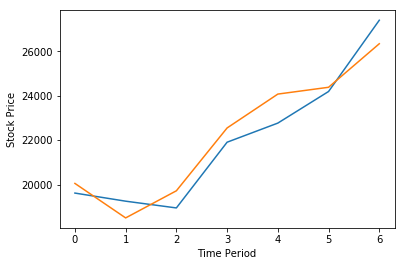

In [239]:
answer=LSTM(txs,7,'WeekNumber_Month_Season_Year' )

In [246]:
len(answer)

2

In [247]:
predict=answer[0]

In [248]:
real=answer[1]

In [252]:
list(predict)

[20050.502, 18498.662, 19718.93, 22545.387, 24069.215, 24375.484, 26333.574]

In [250]:
real

array([ 19616.21999997,  19251.49999997,  18947.80999997,  21904.46999996,
        22764.00999996,  24185.26999996,  27390.80999995])

In [251]:
rmse(predict,real)

812.25033149110504

In [ ]:
denormalizedTestPredictY=[item for sublist in predict for item in sublist]

In [ ]:
denormalizedTestPredictY

In [ ]:
denormalizedTestY=originalSales[train_size+seq_length:]

In [ ]:
# sales=noOutlierSales(sales)
tempxy=[list(txs['season']),list(txs['year']),list(txs['month']),list(txs['week_number']),sales]
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]
xy=np.array(tempxy).transpose().astype(np.float)
originalxy=np.array(tempxy).transpose().astype(np.float)
xy=minMaxNormalizer(xy)

#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=len(tempxy)
#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5
#output_dim(=forecastDays)만큼의 다음날 y_data를 예측

output_dim=forecastDay
#hidden_dim은 정말 임의로 설정
hidden_dim=100
#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01
#iterations는 반복 횟수
iterations=1000
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length - forecastDay):
    _x=x[i:i+seq_length]
    _y = y[i + seq_length:i + seq_length + forecastDay]
    _y = np.reshape(_y, (forecastDay))
#     print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)
    train_size = int(len(dataY) * 0.7)
    
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDay])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
denormalizedTestY=originalSales[train_size+seq_length:]
# denormalizedTestY_original=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalxy)

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [ ]:
print(i for i in list(test_predict[-1]    ))

In [5]:
list(test_predict[  )

[17721.039]

In [6]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [7]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

IndexError: list index out of range

In [ ]:
len(denormalizedTestPredictY)

In [ ]:
denormalizedTestY